<a href="https://colab.research.google.com/github/geonextgis/Image-Analysis-in-Remote-Sensing-with-Python/blob/main/Integration_of_GEE_with_NumPy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Importing Required Libraries**

In [366]:
import ee
import geemap
import matplotlib.pyplot as plt
import seaborn as sns

In [367]:
# Initializing Earth Engine
ee.Initialize()

## **Defining the Region of Interest**



In [368]:
roi = ee.FeatureCollection("users/geonextgis/Bankura_District")

In [369]:
# Initializing a map
map = geemap.Map(height="450px")
map.addLayer(roi)
map.centerObject(roi, 9)

## **Preparing the Dataset**

In [370]:
# Importing Landsat 9 image collection
l9 = ee.ImageCollection("LANDSAT/LC09/C02/T1_L2")

# Filtering the Landsat 9 image collection
filteredL9 = l9.filterBounds(roi)\
               .filterDate("2023-01-01", "2023-12-31")\
               .sort("CLOUD_COVER")\
               .first()\
               .select(["SR_B6", "SR_B5", "SR_B4"])\
               .multiply(0.0000275).add(-0.2)\
               .clip(roi)

# Creating a FCC visulalization
fccVis = {
    "min": 0.0,
    "max": 0.3,
    "bands": ["SR_B6", "SR_B5", "SR_B4"]
}
map.addLayer(filteredL9, fccVis, "Landsat 9 Image")

In [371]:
# Extracting a subset area
roi_subset = ee.Geometry.Polygon([
                                 [87.011035, 23.179817],
                                 [87.104422, 23.179817],
                                 [87.104422, 23.266581],
                                 [87.011035, 23.266581],
                                 [87.011035, 23.179817]
                                 ])

# Clipping the image with the subset area
subset_image = filteredL9.clip(roi_subset)

# Add the subset image to the map
map.addLayer(subset_image, fccVis, "Subset Image")
map.addLayer(roi_subset, {"color": "red"}, "ROI Subset")

# Display the map
map

Map(center=[23.138995392322126, 87.13605475702063], controls=(WidgetControl(options=['position', 'transparent_…

## **Converting EE Image to NumPy Array**

In [372]:
# Converting subset image to numpy array
image_arr = geemap.ee_to_numpy(subset_image)

In [373]:
# Checking the image array information
print(f"Datatype: {type(image_arr)}")
print(f"Shape: {image_arr.shape}")
print(f"Dimensions: {image_arr.ndim}")

Datatype: <class 'numpy.ndarray'>
Shape: (321, 320, 3)
Dimensions: 3


In [374]:
# Checking the numpy array
image_arr

array([[[0.270855 , 0.2290825, 0.10602  ],
        [0.258205 , 0.22427  , 0.107725 ],
        [0.2267725, 0.2585075, 0.0788775],
        ...,
        [0.2373875, 0.2664275, 0.0874575],
        [0.2065325, 0.2509725, 0.0815175],
        [0.2527325, 0.2476725, 0.1140225]],

       [[0.28466  , 0.22669  , 0.1118225],
        [0.27553  , 0.228505 , 0.1162775],
        [0.2349125, 0.2481675, 0.0831675],
        ...,
        [0.2045525, 0.257545 , 0.0718925],
        [0.1039025, 0.156125 , 0.0676025],
        [0.1688025, 0.2055975, 0.085835 ]],

       [[0.2819375, 0.228945 , 0.1169925],
        [0.262055 , 0.234115 , 0.107945 ],
        [0.238295 , 0.2377725, 0.0932875],
        ...,
        [0.2213275, 0.258315 , 0.08347  ],
        [0.16619  , 0.211345 , 0.0756325],
        [0.2281475, 0.2708275, 0.09898  ]],

       ...,

       [[0.2454175, 0.24473  , 0.0877325],
        [0.2554   , 0.2535575, 0.0985675],
        [0.2835875, 0.2624125, 0.108275 ],
        ...,
        [0.26651  , 0.2712

In [375]:
# Getting the maximum and minimum pixel value in the image
print("Maximum Pixel Value in the image:", scaled_arr.max())
print("Minimum Pixel Value in the image:", scaled_arr.min())

Maximum Pixel Value in the image: 255
Minimum Pixel Value in the image: 17


In [376]:
# Scaling the value in the range of 0 to 255
scaled_arr = (scaled_arr[:, :, 0:3]/scaled_arr.max())*255

# Printing the datatype of the scaled array
type(scaled_arr.dtype)

# Changing the datatype to unsigned int8
scaled_arr = scaled_arr.astype("uint8")

# Printing the scaled array
scaled_arr

array([[[121, 103,  47],
        [116, 100,  48],
        [101, 116,  35],
        ...,
        [106, 119,  39],
        [ 92, 112,  36],
        [113, 111,  51]],

       [[128, 101,  50],
        [123, 102,  52],
        [105, 111,  37],
        ...,
        [ 91, 115,  32],
        [ 46,  70,  30],
        [ 75,  92,  38]],

       [[126, 102,  52],
        [117, 105,  48],
        [107, 106,  41],
        ...,
        [ 99, 116,  37],
        [ 74,  95,  34],
        [102, 121,  44]],

       ...,

       [[110, 110,  39],
        [114, 114,  44],
        [127, 118,  48],
        ...,
        [119, 121,  45],
        [119, 118,  46],
        [124, 117,  48]],

       [[112, 115,  41],
        [101, 101,  35],
        [122, 113,  48],
        ...,
        [130, 118,  51],
        [127, 113,  51],
        [120, 101,  49]],

       [[126, 113,  47],
        [100, 109,  37],
        [114, 110,  40],
        ...,
        [136,  99,  54],
        [129,  95,  53],
        [112,  86,  45]]

## **Data Visualization**

In [377]:
# Writing a function to generate histogram of all bands in the array
def plot_histogram(array, bandNames):
  nBands = array.ndim
  fig, ax = plt.subplots(nrows=1, ncols=nBands, figsize=(14, 3))
  fig.subplots_adjust(wspace = 0.28)

  for i in range(nBands):
    band = array[:, :, i].ravel()
    sns.histplot(band, bins=50, ax=ax[i])
    ax[i].set_title(f"{bandNames[i]} Band's Histogram")
    ax[i].set_xlabel("Pixel Values")
    ax[i].title.set_size(10)

# Defining Band Names in a list
bandNames = ["SWIR1", "NIR", "Red"]

# Plotting the histogram of all the bands
plot_histogram(scaled_arr, bandNames)

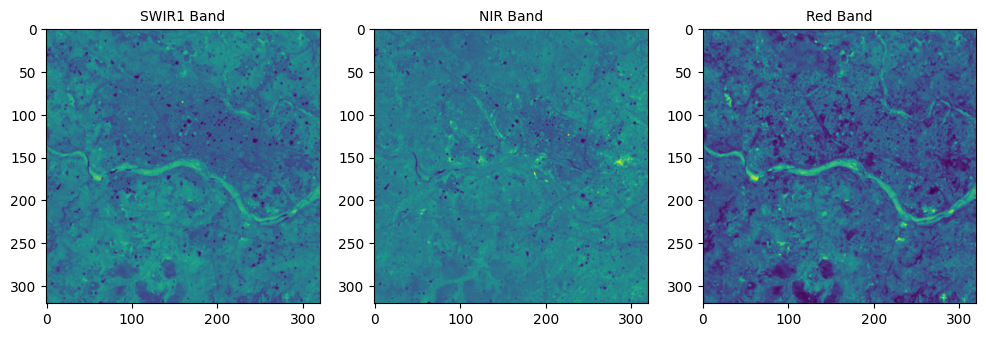

In [378]:
# Writing a function to generate image display of all bands in the array
def plot_image(array, bandNames):
  nBands = array.ndim
  fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

  for i in range(nBands):
    band = array[:, :, i]
    axs[i].imshow(band)
    axs[i].set_title(bandNames[i] + " Band")
    axs[i].title.set_size(10)

# Plotting the image of all the bands
plot_image(scaled_arr, bandNames)